# Quick run

**Problem 2**: What is the optimal size of an electrolysis system and battery for an 10 MW wind turbine offgrid?

**OBS**: This example may take up to 3 min to run depending on your machine specifications

WebIO._IJuliaInit()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
* Solver : Gurobi

* Status
  Result count       : 10
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.04679e+04
  Objective bound    : 5.04679e+04
  Relative gap       : 0.00000e+00
  Dual objective value : 5.04679e+04

* Work counters
  Solve time (sec)   : 1.94404e+01
  Barrier iterations : 0
  Node count         : 8796

 Tech    | Size factor
 WT      | 1.0
 ALK     | 9.9509
 CT      | 1.9494
-----------------------
 power   | 952.37

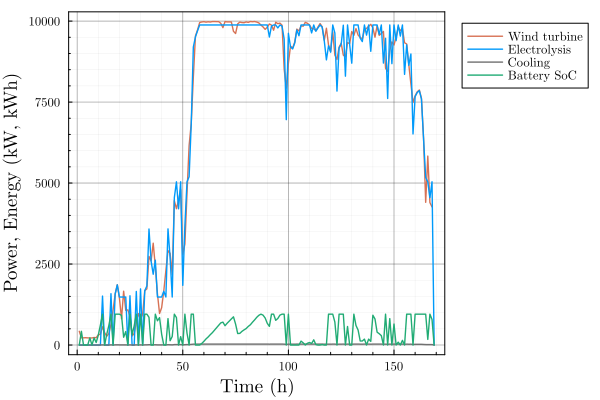

In [1]:
# Including functions
include("../../src/vivi.jl")
using CSV
using DataFrames

##############################
# Techs
##############################
## Electrolysis
# Defining power input of electrolysis
power_in = Resource("power",940.7/0.95+2.7,"kW",[[0],[1]]) # Assuming 95% rectifier efficiency
power_in.loadEffect = [
    [0.15,0.15],[0.51,0.51],[1,1]
    ]

# Defining hydrogen output of electrolysis
hhv_h2 = 141.80E3/3600 # kWh/kg
h2_out = Resource("h2",18.67,"kg/h",[[0],[hhv_h2]])
h2_out.loadEffect = [
    [0.15,0.18],[0.51,0.55],[1.0,1.0]
    ]

# Creating a basic Tech with the information available
alk_in = [power_in]  
alk_out = [h2_out]

alk_q = [Heat(45.54,354,313),
        Heat(23.69, 354, 313),
        Heat(126.67, 354, 353),
        ]

alk = Tech("ALK",alk_in,alk_out,alk_q)

# Adding cost
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
alk_specific_cost = 1E6*CRF # EUR/h-kW
alk.cost = [[[0,0],[100,100*alk_specific_cost]]]

# Adding size limits
alk.limits = [5.0,15.0]

# Adding load limits and shutdown possibility
alk.loads = [0.15,1,true]

## Wind turbine
# Electricity output
df = CSV.read("hourWind.csv",DataFrame)
design_rating = 10E3
HWT = round.(df.load*design_rating,digits=3)

hours = 24*7 # limiting analysis to one week
wt_out = [Resource("power",HWT[1:hours],"kW",[[0],[1]])]

# Creating tech
wt = Tech("WT",[],wt_out,[])

# Adding costs
wt_cost = 20E6*CRF # EUR/h
wt.cost = [[(0,0),(1,wt_cost)]]

# Limiting size
wt.limits  = [1,1]

# Limiting load and shutdown
wt.loads = [1,1,false]

## Cooling tower
ct_in = [Resource("power",14.3,"kW",[[0],[1]])]
ct_heat = [HeatStruct(1000,298,318)]
ct = Tech("CT",ct_in,[],ct_heat) # It needs to check also the min loads with heats

##############################
# Storage
##############################
## Battery
battery = Storage("power",0.0)

# Size limits
battery.limits = [0.0,1.0E3]

# Cost data
bat_specific_cost = 302*CRF # EUR/kWh
battery.cost = [
    [
        [0,0],[1.0E3,1E3*bat_specific_cost]
    ]
]

##############################
# Output
##############################
# Hydrogen
c_h2 = 5 # EUR/kg
hhv_h2 = 141.80E3/3600 # kWh/kg
h2 = Resource("h2",[Inf for i=1:hours],"kg/h",[[c_h2 for i=1:hours],[hhv_h2 for i=1:hours]])

# Curtailment
cut = Resource("power",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours],[0 for i=1:hours]])

##############################
# Problem
##############################

inputs = []
processes = [wt,alk]
utilities = [ct]
outputs = [h2,cut]
storage = [battery]
problem = Problem(inputs,processes,outputs,utilities,storage)
answer = vivi(problem,solver="Gurobi",capex=true) # Gurobi solver is much faster

# Plotting
plot(HWT[1:hours],label="Wind turbine",xlabel="hour",ylabel="Energy (kW or kWh)")
plot!(answer.processes[2].size*(940.7/0.95+2.7),label="Electrolysis")
plot!(answer.utilities[1].size*14.3,label="Cooling")
plot!(answer.storage[1].size,label="Battery SoC")

xaxis!("Time (h)")
yaxis!("Power, Energy (kW, kWh)")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
* Solver : Gurobi

* Status
  Result count       : 10
  Termination status : TIME_LIMIT
  Message from the solver:
  "Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.15565e+04
  Objective bound    : 5.15790e+04
  Relative gap       : 4.36662e-04
  Dual objective value : 5.15790e+04

* Work counters
  Solve time (sec)   : 1.80058e+02
  Barrier iterations : 0
  Node count         : 271102

 Tech    | Size factor
 WT      | 1.0
 ALK     | 9.7118
 CT      | 1.9025
-----------------------
 power   | 10000.0


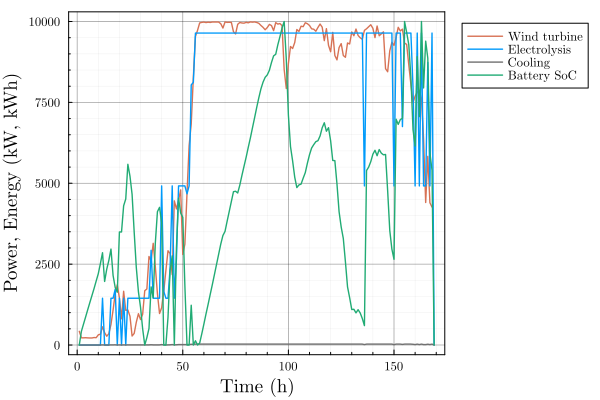

In [4]:
# Including functions
include("../../src/vivi.jl")
using CSV
using DataFrames

##############################
# Techs
##############################
## Electrolysis
# Defining power input of electrolysis
power_in = Resource("power",940.7/0.95+2.7,"kW",[[0],[1]]) # Assuming 95% rectifier efficiency
power_in.loadEffect = [
    [0.15,0.15],[0.51,0.51],[1,1]
    ]

# Defining hydrogen output of electrolysis
hhv_h2 = 141.80E3/3600 # kWh/kg
h2_out = Resource("h2",18.67,"kg/h",[[0],[hhv_h2]])
h2_out.loadEffect = [
    [0.15,0.18],[0.51,0.55],[1.0,1.0]
    ]

# Creating a basic Tech with the information available
alk_in = [power_in]  
alk_out = [h2_out]

alk_q = [Heat(45.54,354,313),
        Heat(23.69, 354, 313),
        Heat(126.67, 354, 353),
        ]

alk = Tech("ALK",alk_in,alk_out,alk_q)

# Adding cost
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
alk_specific_cost = 1E6*CRF # EUR/h-kW
alk.cost = [[[0,0],[100,100*alk_specific_cost]]]

# Adding size limits
alk.limits = [5.0,15.0]

# Adding load limits and shutdown possibility
alk.loads = [0.15,1,true]

## Wind turbine
# Electricity output
df = CSV.read("hourWind.csv",DataFrame)
design_rating = 10E3
HWT = round.(df.load*design_rating,digits=3)

hours = 24*7 # limiting analysis to one week
wt_out = [Resource("power",HWT[1:hours],"kW",[[0],[1]])]

# Creating tech
wt = Tech("WT",[],wt_out,[])

# Adding costs
wt_cost = 20E6*CRF # EUR/h
wt.cost = [[(0,0),(1,wt_cost)]]

# Limiting size
wt.limits  = [1,1]

# Limiting load and shutdown
wt.loads = [1,1,false]

## Cooling tower
ct_in = [Resource("power",14.3,"kW",[[0],[1]])]
ct_heat = [HeatStruct(1000,298,318)]
ct = Tech("CT",ct_in,[],ct_heat) # It needs to check also the min loads with heats

##############################
# Storage
##############################
## Battery
battery = Storage("power",0.0)

# Size limits
battery.limits = [0.0,1.0E4]

# Cost data
bat_specific_cost = 302*CRF # EUR/kWh
battery.cost = [
    [
        [0,0],[1.0E4,0E3*bat_specific_cost]
    ]
]

##############################
# Output
##############################
# Hydrogen
c_h2 = 5 # EUR/kg
hhv_h2 = 141.80E3/3600 # kWh/kg
h2 = Resource("h2",[Inf for i=1:hours],"kg/h",[[c_h2 for i=1:hours],[hhv_h2 for i=1:hours]])

# Curtailment
cut = Resource("power",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours],[0 for i=1:hours]])

##############################
# Problem
##############################

inputs = []
processes = [wt,alk]
utilities = [ct]
outputs = [h2,cut]
storage = [battery]
problem = Problem(inputs,processes,outputs,utilities,storage)
answer = vivi(problem,solver="Gurobi",capex=true) # Gurobi solver is much faster

# Plotting
plot(HWT[1:hours],label="Wind turbine",xlabel="hour",ylabel="Energy (kW or kWh)")
plot!(answer.processes[2].size*(940.7/0.95+2.7),label="Electrolysis")
plot!(answer.utilities[1].size*14.3,label="Cooling")
plot!(answer.storage[1].size,label="Battery SoC")

xaxis!("Time (h)")
yaxis!("Power, Energy (kW, kWh)")

# Step-by-step

### Including vivi

Let's import the vivi functions and structures that will help us to solve the problem

In [4]:
# Including functions
include("../../src/vivi.jl")
using CSV
using DataFrames

## Techs

### Alkaline electrolysis

Alkaline electrolysis efficiency varies with load. We can add this detail by modifying the **loadEffect** attribute in resources:


            resource.loadEffect = [
                [load_1, percentage_1],
                [load_2, percentage_2],
                ...
            ]

In this case, **percentage** refers to the percentage of the resource amount that is produced at that specific load point.

In [5]:
# Defining power input of electrolysis
power_in = Resource("power",940.7/0.95+2.7,"kW",[[0],[1]]) # Assuming 95% rectifier efficiency
power_in.loadEffect = [
    [0.15,0.15],[0.51,0.51],[1,1]
    ]

# Defining hydrogen output of electrolysis
hhv_h2 = 141.80E3/3600 # kWh/kg
h2_out = Resource("h2",18.67,"kg/h",[[0],[hhv_h2]])
h2_out.loadEffect = [
    [0.15,0.18],[0.51,0.55],[1.0,1.0]
    ]

# Creating a basic Tech with the information available
alk_in = [power_in]  
alk_out = [h2_out]

alk_q = [Heat(45.54,354,313),
        Heat(23.69, 354, 313),
        Heat(126.67, 354, 353),
        ]

alk = Tech("ALK",alk_in,alk_out,alk_q)

Tech("ALK", Any[Resource("power", Real[992.9105263157896], "kW", Vector{Real}[[0], [1]], Vector{Real}[[0.15, 0.15], [0.51, 0.51], [1.0, 1.0]])], Any[Resource("h2", Real[18.67], "kg/h", Vector{Real}[[0.0], [39.388888888888886]], Vector{Real}[[0.15, 0.18], [0.51, 0.55], [1.0, 1.0]])], HeatStruct[HeatStruct(45.54, 354.0, 313.0, 0.0, Vector{Real}[]), HeatStruct(23.69, 354.0, 313.0, 0.0, Vector{Real}[]), HeatStruct(126.67, 354.0, 353.0, 0.0, Vector{Real}[])], Real[0.0, 1000.0], [[[0.0, 0.0], [1000.0, 0.0]]], Real[0, 1, 1], Real[-1, 1], Real[1])

In addition each Tech has a number of attributes which we can set to better represent the problem:

* **limits**: specify the size limits of the technology

                tech.limits = [min,max] # min <= size <= max 

* **cost**: specify the cost data for different sizes of the technology

                tech.cost = [
                    [
                        [size_1, cost_1],
                        [size_2, cost_2],
                        ...
                    ],
                    ...     # in the case there is more than one type of cost/value
                ]

* **loads**: specify the minimal/maximum load of the technology and if it can be shutted off.

                tech.loads = [min,max,on_off] # min <= load <= max

    * if **on_off** is *true*, then the technology can be shut down (i.e. load == 0 is valid)
    * if **on_off** is *false*, then the technology cannot be shut down (i.e. load != 0)

In our case, we would like to add the following caracteristics:
* Specific cost = 1 MEUR / kW
* Size limits = 5-15x
* Load limits = 0% or 15-100% (with shutdown)

In [6]:
# Adding cost
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
alk_specific_cost = 1E6*CRF # EUR/h-kW
alk.cost = [[[0,0],[100,100*alk_specific_cost]]]

# Adding size limits
alk.limits = [5.0,15.0]

# Adding load limits and shutdown possibility
alk.loads = [0.15,1,true]

3-element Vector{Float64}:
 0.15
 1.0
 1.0

### Wind turbine

Similarly, we can define a wind turbine as a Tech that outputs different amounts of electricity per hour. In this analysis we will limit the number of hours to 168 (one week) in order to solve the optimization quickly.
* Specific cost = 2 MEUR / MW
* Size limits = 1x
* Load limits = 100% (without shutdown)

In [7]:
using CSV
using DataFrames

# Electricity output
df = CSV.read("hourWind.csv",DataFrame)
design_rating = 10E3
HWT = round.(df.load*design_rating,digits=3)

hours = 24*7 # limiting analysis to one week
wt_out = [Resource("power",HWT[1:hours],"kW",[[0],[1]])]

# Creating tech
wt = Tech("WT",[],wt_out,[])

# Adding costs
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
wt_cost = 20E6*CRF # EUR/h
wt.cost = [[(0,0),(1,wt_cost)]]

# Limiting size
wt.limits  = [1,1]

# Limiting load and shutdown
wt.loads = [1,1,false]

3-element Vector{Int64}:
 1
 1
 0

**OBS**: Note that we are limiting the size of the wind turbine to 1 because the size is fixed to 10 MW. In addition loads are fixed to 100% without the possibility of shutdown because the power output already accounts for the turbine loads and shutdown effects. 

### Cooling tower

A cooling water can be added as a simple Tech with a heat sink. For simplicity we are not going to consider the costs and partial load efficiencies of the coolwing tower.

In [8]:
# Cooling tower
ct_in = [Resource("power",14.3,"kW",[[0],[1]])]
ct_heat = [HeatStruct(1000,298,318)]
ct = Tech("CT",ct_in,[],ct_heat) # It needs to check also the min loads with heats

Tech("CT", Any[Resource("power", Real[14.3], "kW", Vector{Real}[[0], [1]], Vector{Real}[])], Any[], HeatStruct[HeatStruct(1000.0, 298.0, 318.0, 0.0, Vector{Real}[])], Real[0.0, 1000.0], [[[0.0, 0.0], [1000.0, 0.0]]], Real[0, 1, 1], Real[-1, 1], Real[1])

### Battery

Storages in vivi are perfect reservoirs of resources that can have a cost associated with it. The construction is simple:

                store = Storage(type,initial_ammount)

As it with Techs, we can set the min-max sizes and costs for the storage. For a simple battery, for instance:

In [9]:
# Battery
battery = Storage("power",0.0)

# Size limits
battery.limits = [0.0,1.0E3]

# Cost data
bat_specific_cost = 302*CRF # EUR/kWh
battery.cost = [
    [
        [0,0],[1.0E3,1E3*bat_specific_cost]
    ]
]

1-element Vector{Vector{Vector{Float64}}}:
 [[0.0, 0.0], [1000.0, 3.5113432722136384]]

## Output

The two outputs that we are going to consider in this analysis are the hydrogen and the curtailment of electricity:

In [10]:
# Output
c_h2 = 5 # EUR/kg
hhv_h2 = 141.80E3/3600 # kWh/kg
h2 = Resource("h2",[Inf for i=1:hours],"kg/h",[[c_h2 for i=1:hours],[hhv_h2 for i=1:hours]])
cut = Resource("power",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours],[0 for i=1:hours]])

Resource("power", Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], "kg/h", Vector{Real}[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], Vector{Real}[])

**OBS**: Note that we have to define an amount and value for each hour of the analysis

## Problem and solution

In this case, since there are lots of variables, it is better to use the Gurobi solver. In addition, we should make it explicit to the solver that we would like to use the CAPEX estimations:

In [11]:
inputs = []
processes = [wt,alk]
utilities = [ct]
outputs = [h2,cut]
storage = [battery]
problem = Problem(inputs,processes,outputs,utilities,storage)
answer = vivi(problem,solver="Gurobi",capex=true) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
* Solver : Gurobi

* Status
  Result count       : 10
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.04679e+04
  Objective bound    : 5.04679e+04
  Relative gap       : 0.00000e+00
  Dual objective value : 5.04679e+04

* Work counters
  Solve time (sec)   : 1.49710e+01
  Barrier iterations : 0
  Node count         : 8796

 Tech    | Size factor
 WT      | 1.0
 ALK     | 9.9509
 CT      | 1.9494
-----------------------
 power   | 952.37


Problem(Any[], Any[Tech("WT", Any[], Any[Resource("power", Real[422.778, 222.922, 221.496, 225.441, 219.972, 217.2, 217.286, 231.432, 226.091, 314.469  …  7486.75, 7691.875, 7816.905, 7872.85, 7616.892, 6378.405, 4405.599, 5831.96, 4397.958, 4264.613], "kW", Vector{Real}[[0], [1]], Vector{Real}[])], HeatStruct[], Real[1, 1], Vector{Tuple{Int64, Real}}[[(0, 0), (1, 232.53928955057208)]], Real[1, 1, 0], Real[-1, 1], Real[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]), Tech("ALK", Any[Resource("power", Real[992.9105263157896], "kW", Vector{Real}[[0], [1]], Vector{Real}[[0.15, 0.15], [0.51, 0.51], [1.0, 1.0]])], Any[Resource("h2", Real[18.67], "kg/h", Vector{Real}[[0.0], [39.388888888888886]], Vector{Real}[[0.15, 0.18], [0.51, 0.55], [1.0, 1.0]])], HeatStruct[HeatStruct(45.54, 354.0, 313.0, 0.0, Vector{Real}[]), HeatStruct(23.69, 354.0, 313.0, 0.0, Vector{Real}[]), HeatStruct(126.67, 354.0, 353.0, 0.0, Vector{Real}[])], Real[5.0, 15.

The solution gives the optimal sizes for the system components. The maximum revenue is estimated as **50,468 EUR/week** for the cost and wind power profile assumed.

What is interesting to observe is that the size of the AEC system is slighly undersized, as it can be observed by plotting energy produced/consumed by the system:

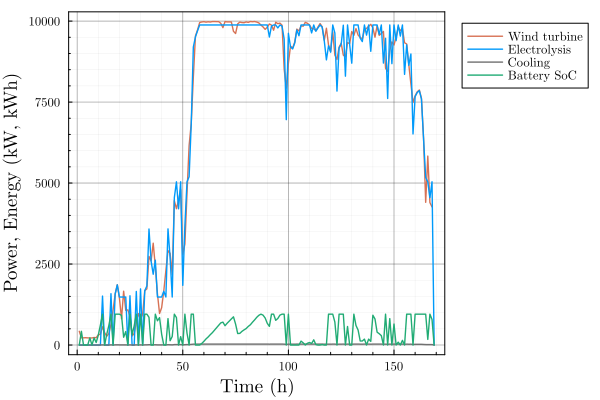

In [12]:
# Plotting first 10 days
plot(HWT[1:hours],label="Wind turbine",xlabel="hour",ylabel="Energy (kW or kWh)")
plot!(answer.processes[2].size*(940.7/0.95+2.7),label="Electrolysis")
plot!(answer.utilities[1].size*14.3,label="Cooling")
plot!(answer.storage[1].size,label="Battery SoC")

xaxis!("Time (h)")
yaxis!("Power, Energy (kW, kWh)")

**Example**: plotting the Sankey diagram for time = 150 using the second value index (energy)

In [13]:
vivi_sankey(answer,valueIndex=2,time=150)

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

**Example**: plotting the composite curve for time = 150

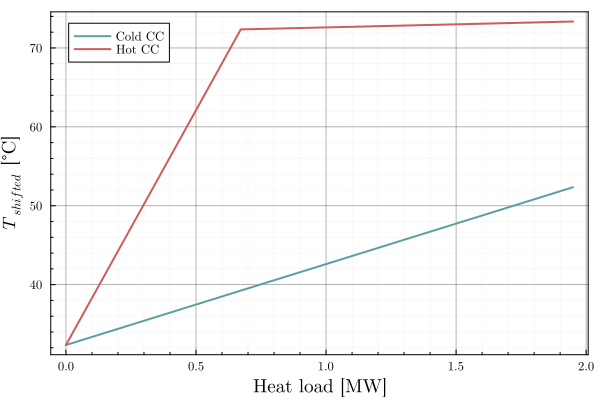

In [14]:
vivi_cc(answer,time = 150)